## Solarsystem

Um ein Solarsystem nach dem Vorbild des Unseren zu simulieren haben wir in der Datei Solar.py die Massen, 
Distanzen zur Sonne und Bahngeschwindigkeiten von den Planeten und unserem Mond definiert.

In [210]:
import Solar as sol
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import progressBar

## Einheiten

Beim verlet-Algorithmus werden für $n$ Iterationen mit dem Zeitschritt $h$ Position $\vec{r}$ und Geschwindigkeit $\vec{v}$ folgender Zeitpunkte ausgerechnet:
$$ \vec{r}(t_0 + h \cdot i) $$
$$ \vec{v}(t_0 - \frac{h}{2} + h \cdot i) $$
wobei
$$ i \in {1,...,n} $$
Die Werte für $\vec{r}(t)$ und $\vec{v}(t)$ werden dabei in folgendermaßen berechnet:
$$ \vec{r}(t) = \vec{r}(t-h) + h \cdot \vec{v}(t-\frac{h}{2})$$
$$ \vec{v}(t) = \vec{v}(t-h) + h \cdot \vec{a}(t-\frac{h}{2})$$
Dabei ist $\vec{a}(t)$ die Beschleunigung, die aus $\vec{r}(t)$ folgendermaßen berechnet wird:
$$ \vec{a} = \frac{\vec{F}}{m} $$
$$ \vec{F} = G \cdot m \cdot \sum_{j=1}^p\frac{m_j}{|\vec{r_j}-r|^2}$$
$$ \Rightarrow \vec{a} = G \cdot \sum_{j=1}^p\frac{m_j}{|\vec{r_j}-r|^2}$$
Dabei sind $m_j$ die Massen und $\vec{r_j}$ die Ortsvektoren der $p$ anderen Körper im System.
Um das ständige Multiplizieren mit der Gravitationskonstante $G$ wärend der Simulation zu vermeiden, können wir stattdessen einfach zu Beginn alle Massen jeweis mit ihr multiplizieren und diese Größe statt der Masse unter particle.mass speichern. Dann berechnet sich die Beschleunigung folgendermaßen:
$$ \vec{a} = \sum_{j=1}^p\frac{\lambda_j}{|\vec{r_j}-r|^2}$$
mit $$ \lambda_j = m_j \cdot G $$
Dabei sind $\lambda_j$ die mit der Gravitationskonstante multiplizierten massen particle.mass.
Die Massen werden im Code aber auch für die Berechnung der kinetischen und potentiellen Energie verwendet, also muss bei diesen Berechnungen die Masse durch $\frac{\lambda}{G}$ ersetzt werden:
$$ W_{pot}=G\frac{-m_1 \cdot m_2}{|\vec{r_1}-\vec{r_2}|} = \frac{1}{G} \cdot \frac{-\lambda_1 \cdot \lambda_2}{|\vec{r_1}-\vec{r_2}|}$$
$$ W_{kin}=\frac{1}{2} \cdot m \cdot v^2 = \frac{1}{G} \cdot \lambda \cdot v^2$$
Bei diesen Formeln sieht man dann, dass man die Gravitationskonstante einfach weglassen kann, und alle Energien werden mit dem gleichen Faktor skaliert, sodass alle Verhältnisse noch Stimmen.

In [211]:
class Particle:

    """
    Physics for a Particle and it's interaction with another

    @params
        name        - Required  : name of the particle set
        mass        - Required  : mass        
        coord       - Required  : coordinates in dict {x: , y: , z: }    
        velocity    - Required  : velocity in dict {x: , y: , z: }
        color       - Required  : HEX code, or Color name
    """

    def __init__(self, name, mass, coord, velocity, color):
        self.name = name
        self.mass = mass
        self.coord = np.array([coord["x"], coord["y"], coord["z"]])
        self.velocity = np.array([velocity["x"], velocity["y"], velocity["z"]])
        self.color = color

    def move(self, dt):

        """
        Applies a movement with the particles currently set velocity
        for the timestep of dt to it.

        @params
            dt          - Required  : time for which the velocity should be applied to the coordinates
        """ 

        delta = self.velocity * dt
        self.coord = self.coord + delta

    def kineticEnergy(self):
        """
        returns the particles current kinetic energy
        """ 
        return self.mass / 2 * np.linalg.norm(self.velocity)**2

    def momentum(self):
        """
        returns the particles current momentum vector
        """
        return self.mass * self.velocity

    def phi(self):
        """
        returns the particles current angle in radian relative to the coordinate system
        """
        radianHalf = np.arccos(self.coord[0] / np.linalg.norm(np.array([self.coord[0], self.coord[1]])) )
        if self.coord[1] < 0:
            return 2 * np.pi - radianHalf
        return radianHalf 

    def potEnergy(self, otherParticle):
        """
        returns the particles current potential energy in the gravity field of the other particle

        @params
            otherParticle : the particle with the gravity field
        """
        diff = np.subtract(self.coord, otherParticle.coord)
        radius = np.linalg.norm(diff)
        return - self.mass * otherParticle.mass / radius

    def accelerate(self, other, dt):
        """
        adjusts the velocity of two particles, based on the gravity force they apply to each other.

        @params
            otherParticle : the particle that's responsible for the acceleration
        """
        diff = np.subtract(other.coord, self.coord)
        radius = np.linalg.norm(diff)
        self.velocity = self.velocity + diff * other.mass * dt / (radius**3)
        other.velocity = other.velocity - diff * self.mass * dt / (radius**3)
        # return force that applys on self

## Particle Factory

Im folgenden definieren wir einige Sets an Himmelskörpern -> "Particles" für die folgenden Simulationen und
eine Methode um die Geschwindigkeiten von Particles in einer Liste so zu "shiften", dass der Schwerpunkt des Systems konstant ist. 

In [212]:
class ParticleFactory:

    """
    Class to handle a set of particle and use it in a simulation

    @params
        name        - Required  : name of the predefined particle set
    """

    def __init__(self, name):
        self.name = name
        self.particleList = []
        self.setParticles()
        self.colors = [p.color for p in self.particleList]
        self.masses = [p.mass for p in self.particleList]
        maxsize = max(self.masses) ** (1/8)
        self.sizes = list(map(lambda x: x**(1/8) / maxsize * 69, self.masses))

    def importParticles(self, particles):
        self.particleList = particles

    def setParticles(self):
        if self.name == "Solar":
            star = Particle("Sun", sol.mass_sun, {"x": 0, "y": 0, "z": 0}, {
                            "x": 0, "y": 0, "z": 0}, "yellow")
            # star = Particle("sun", 1000, {"x": 0, "y": 0, "z": 0 },{"x": -0.001, "y": 0, "z": 0 } )
            mercury = Particle("Mercury", sol.mass_mercury, {"x": 0, "y": sol.distance_mercury, "z": 0}, {
                "x": sol.velocity_mercury, "y": 0, "z": 0}, "#DDCC44")
            venus = Particle("Venus", sol.mass_venus, {"x": 0, "y": sol.distance_venus, "z": 0}, {
                "x": sol.velocity_venus, "y": 0, "z": 0}, "#884400")
            earth = Particle("Earth", sol.mass_earth, {"x": 0, "y": sol.distance_earth, "z": 0}, {
                "x": sol.velocity_earth, "y": 0, "z": 0}, "steelblue")
            mars = Particle("Mars", sol.mass_mars, {"x": 0, "y": sol.distance_mars, "z": 0}, {
                            "x": sol.velocity_mars, "y": 0, "z": 0}, "#EE1111")
            jupiter = Particle("Jupiter", sol.mass_jupiter, {"x": 0, "y": sol.distance_jupiter, "z": 0}, {
                "x": sol.velocity_jupiter, "y": 0, "z": 0}, "chocolate")
            saturn = Particle("Saturn", sol.mass_saturn, {"x": 0, "y": sol.distance_saturn, "z": 0}, {
                "x": sol.velocity_saturn, "y": 0, "z": 0}, "goldenrod")
            uranus = Particle("Uranus", sol.mass_uranus, {"x": 0, "y": sol.distance_uranus, "z": 0}, {
                "x": sol.velocity_uranus, "y": 0, "z": 0}, "lightseagreen")
            neptune = Particle("Neptune", sol.mass_neptune, {"x": 0, "y": sol.distance_neptune, "z": 0}, {
                "x": sol.velocity_neptune, "y": 0, "z": 0}, "cornflowerblue")
            moon = Particle("Moon", sol.mass_moon, {"x": sol.distance_moon, "y": sol.distance_earth, "z": 0}, {
                            "x": sol.velocity_earth, "y": sol.velocity_moon, "z": 0}, "#666666")
            self.particleList = [star, mercury, venus, earth, mars, jupiter, saturn, uranus, moon]

        if self.name == "Tatoo":
            sun1 = Particle("Tatoo I", 50, {"x": 0, "y": 10, "z": 0}, {
                            "x": -1, "y": 0, "z": 0}, "peachpuff")
            sun2 = Particle(
                "Tatoo II", 50, {"x": 0, "y": -10, "z": 0}, {"x": 1, "y": 0, "z": 0}, "orange")
            planet = Particle("Planet", 1, {"x": 100, "y": 0, "z": 0}, {
                "x": 0, "y": 1, "z": 0}, "cadetblue")

            self.particleList = [sun1, sun2]
            #self.particleList =[sun1, sun2, planet]

        if self.name == "Elipse":
            star = Particle("Star", 1000, {"x": 0, "y": 0, "z": 0}, {
                            "x": 0, "y": 0, "z": 0}, "orange")
            planet = Particle("Pluto", 1, {"x": 100, "y": 0, "z": 0}, {
                "x": 0, "y": 1.3, "z": 0}, "cadetblue")

            self.particleList = [star, planet]

        if self.name == "Moon System":
            star = Particle("Star", 1000, {"x": 0, "y": 0, "z": 0}, {
                            "x": 0, "y": 0, "z": 0}, "orange")
            planet = Particle("Planet", 10, {"x": 100, "y": 0, "z": 0}, {
                "x": 0, "y": 3, "z": 0}, "cadetblue")
            moon = Particle("Moon", 1, {"x": 100, "y": 4, "z": 0}, {
                            "x": 1, "y": 3, "z": 0}, "black")
            self.particleList = [star, planet, moon]

        if self.name == "Lagrangepoints":
            star = Particle("Star", 1000, {"x": 0, "y": 0, "z": 0}, {
                            "x": 0, "y": 0, "z": 0}, "yellow")
            planet = Particle("Planet", 7, {"x": 100, "y": 0, "z": 0}, {
                "x": 0, "y": 3, "z": 0}, "green")
            # l1 = Particle("L1", 0.01, {"x": 100/(sqrt(50)+1)*sqrt(50), "y": 0, "z": 0}, {
            #                "x": 0, "y": 3/(sqrt(50)+1)*sqrt(50), "z": 0}, "black")
            # l2 = Particle("L2", 0.01, {"x": 100, "y": 0, "z": 0}, {
            #                "x": 0, "y": 3, "z": 0}, "black")
            l3 = Particle("L3", 0.01, {"x": -100, "y": 0, "z": 0}, {
                "x": 0, "y": -3, "z": 0}, "black")
            l4 = Particle("L4", 0.01, {"x": 100*np.cos(np.pi/3), "y": -100*np.sin(np.pi/3), "z": 0}, {
                "x": 3*np.sin(np.pi/3), "y": 3*np.cos(np.pi/3), "z": 0}, "black")
            l5 = Particle("L5", 0.01, {"x": 100*np.cos(np.pi/3), "y": 100*np.sin(np.pi/3), "z": 0}, {
                "x": -3*np.sin(np.pi/3), "y": 3*np.cos(np.pi/3), "z": 0}, "black")
            self.particleList = [star, planet, l3, l4, l5]

        if self.name == "Phase Room":
            parts = [Particle("Star", 100000, {"x": 0, "y": 0, "z": 0}, {
                "x": 0, "y": 0, "z": 0}, "yellow")]

            for i in range(10):
                parts.append(Particle("Planet {}".format(i), 1, {"x": 0, "y": (
                    i+1)*500, "z": 0}, {"x": 10-i, "y": 0, "z": 0}, '#' + str(i)*6))
            self.particleList = parts

    def removeOffsetSpeed(self):
        """
        Determindes the velocity of the center of mass of the particle set.
        Offsets all particles velocity by the negative of this velocity.
        This sets the total momentum of the particle set to zero.
        """
        totalMomentum = np.array([float(0), float(0), float(0)])
        totalMass = 0
        for p in self.particleList:
            totalMomentum = np.add(totalMomentum, p.momentum())
            totalMass += p.mass
        totalVelocity = totalMomentum / totalMass
        for p in self.particleList:
            p.velocity = np.subtract(p.velocity, totalVelocity)


## Simulate

Die Bewegungsgleichung für 3 oder mehr Körper lässt sich im Allgemeinen nicht analytisch lösen.<br>
Numerisch gibt es verschieden Anstäze:

<b>Trivial Euler Verfahren:</b>

Zu einer Startposition $\vec{r}(0)$ mit gegebenem $\vec{v}(0)$ und einem gewählten Zeitschritt $dt$, berechnet man iterativ die Koordinaten für die folgenden Koordinaten nach der Vorschrift:
$$\vec{r}(t+dt)=\vec{r}(t) + dt \cdot \vec{v}(t)$$
wobei sich jeweils das neue $\vec{v}(t)$ für einen nächsten Schritt aus der Kraft $\vec{F}(r)$ welche bei \vec{r}(t) auf den Körper wirkt berechnet.
$$\vec{a}=\vec{F}/m \\ \vec{v}(t+dt)=\vec{v}(t)+\vec{a}(t+dt) \cdot dt$$
Um die weiteren Zeitschritte zu berechnen, ist das erfahren zu Widerholen bzw. $t=t+dt$ zu setzen.<br>
Dieses Verfahren ist aber sehr instabil, denn selbst bei einer konstanten Beschleunigung ist die Geschwindigkeit mit der bei einem Zeitschritt gerechnet wird immer nur für den Anfangszeitpunkt des Zeitschrittes exakt und danach immer zu wenig in die beschleunigte Richtung. Für eine konstante Kraft kommt so in jedem Zeitschritt der gleiche Fehler hinzu und der summiert sich auf und wird immer größer. Beim Beispiel der Planetenbewegung ist die Kraft zwar nicht konstant, aber immer nach innen gerichtet, sodass der Planet bei dem Verfahren immer nicht weit genug nach innen beschleunigt wird, und immer weiter nach außen wegdriftet.
Berechnet man zu erst $\vec{v}(t + dt)$ und mit dieser Geschwindigkeit dann $\vec{r}(t + dt)$ so wird die Beschleunigung zu weit nach innen gerichtet sein, und der Planet immer weiter nach innen driften.<br>
<br>
Durch möglichst kleine Zeitschritte lässt sich der Fehler und damit der Drift zwar minimieren aber nicht beseitigen.
Vergleichbar mit der Unter und Obersumme beim Integrieren.

<b>Besser Verlet Verfahren:</b>

Vor dem ersten Schritt berechnet man die Kraft $\vec{F}(r)$ und die daraus resultierende Beschleunigung $\vec{a}=\vec{F}/m$ die auf den Körper an den entsprechenden Startkoordinaten wirkt.<br>
Dann passt man die Geschwindigkeit nur um die Beschleunigung für einen halben Zeitschritt an: $$\vec{v}(t + ½ dt) = \vec{v}(t) + ½ dt \cdot \vec{a}(t)$$.
Wenn wir von nun an \vec{r}(t + dt) berechnen machen wir das auf der Grundlage von \vec{v}(t + ½ dt )<br>
Und wenn wir \vec{v}(t + dt + ½ dt ) berechnen machen wir das auf der Grundlage von \vec{F}(t + dt).<br>
Dann werden in jedem Zeitschritt die Koordinaten $\vec{r}(t+dt)=\vec{r}(t)+\vec{v}(t+½ \cdot dt) \cdot dt$ anhand der Geschwindigkeit zum Zeitpunkt in der Mitte des Zeitschrittes berechnet. Und die Geschwindigkeit $\vec{v}(t+3/2 \cdot dt)=\vec{v}(t+½ \cdot dt)+\vec{a}(t+dt) \cdot dt$ wird anhand der Beschleunigung aus der Kraft zu den Koordinaten von ganzzahligen Zeitschritten berechnet, wobei das wieder die Beschleunigung zu dem Zeitpunkt ist, der genau in der Mitte zwischen den Zeitpunkten liegt, für die die Geschwindigkeiten berechnet wurden.
Also wäre die Rechnung schonmal für sich linear mit der Zeit ändernde Beschleunigungen und Geschwindigkeiten exakt und der Rechenaufwand ist kaum gestiegen
Das Verlet verfahren lässt sich auch über eine Taylorentwicklung zur 3. Ordnung von der Mitte in beide Richtungen herleiten, der Fehler liegt damit erst in 4. Ordnung. Die antisymmetrische Anordnung des 1. und 3. Terms lässt sich diese wegkürzen, sodass der Rechenaufwand niedrig bleibt.
Da das Verlet-Verfahren ein symplektisches ist bleibt beim Verlet-Verfahren das Volumen des Phasenraums erhalten.

In [213]:
class Simulate:
    """
    Class for Simulations

    @params
        h           - Required  : size of timestep (float)
        n           - Required  : number of timesteps (int)
    """

    def __init__(self, h: float, n: int ):
      
        self.h = h
        self.n = n

    def verlet(self, particles: list[Particle]):
        
        """
        Calculates the movement of particles with Verlet algorithm
        Returns positions in multidimensional array [particle p][dimension 0-2][timestep i].
        Returns maximum and minimum of the coordinates too
       
        """

        mmin = np.amin(particles[0].coord)
        mmax = np.amax(particles[0].coord)
        t_axis = np.linspace(0, self.n*self.h, num=self.n)
        energy = np.zeros(self.n)
        p_axes = []
        p_momentum = []
        p_radius = []
        p_phi = []

        center =  np.array([float(0), float(0), float(0)])
        masssum = 0
        for p in particles:
            p_axes.append([np.zeros(self.n), np.zeros(self.n), np.zeros(self.n)])
            masssum += p.mass
            center += p.coord * p.mass 
            p_momentum.append(np.zeros(self.n))
            p_phi.append(np.zeros(self.n))
            p_radius.append(np.zeros(self.n))
        center *= (1/masssum)

        for pti in particles:
            for ptj in particles: 
                if ptj == pti:
                    break
                # Vor dem Ersten Schritt die Beschleunigung für einen halben Zeitschritt auf den Körper anwenden.
                pti.accelerate(ptj, self.h/2)
        for i in range(self.n):
            for pt in particles:
                pt.move(self.h)
            for pti in particles:
                for ptj in particles: 
                    if pti == ptj:
                        break
                    energy[i] += pti.potEnergy(ptj)
                    #force = pti.gravityForce(ptj)
                    #pti.accelerate(force, self.h)
                    #ptj.accelerate(force, self.h)
                    pti.accelerate(ptj, self.h)
            for p, pt in enumerate(particles):
                energy[i] += pt.kineticEnergy()
                p_momentum[p][i] = np.linalg.norm(pt.momentum())
                p_radius[p][i] = np.linalg.norm(np.subtract(pt.coord, center) )
                p_phi[p][i] = pt.phi()
                p_axes[p][0][i] = pt.coord[0]
                p_axes[p][1][i] = pt.coord[1]
                p_axes[p][2][i] = pt.coord[2]
                mmin = min(mmin, np.amin(pt.coord))
                mmax = max(mmax, np.amax(pt.coord))
            if (i+1)/self.n*100%5 == 0: 
                progressBar.draw(i, self.n, "Verlet", "Complete", length=50)

        return (p_axes, p_momentum, p_radius, p_phi, energy, t_axis, mmin, mmax)

# Animate Class

Bekommt eine particle Factory übergeben, aus dieser werden die Particle, deren Farben und Größen gewonnen.<br>
Bekommt eine simulator Funktion wie etwa verlet() aus der Simulate class übergeben. Das zu ihr gehörige simulator Objekt, kennt die Anzahl und Größe der Zeitschritte n und h, so dass die simulator Funktion nur die partliceList übergeben bekommen muss.

Die Simulate class gibt wie oben gesehen allerlei werte zurück, die für das Plotten relevant sind.

In [214]:
from collections.abc import Callable

class Animate:
    """Animated scatter plot and charts using matplotlib.animations.FuncAnimation.

        @params
            particleFactory  - Required  : array of Objects from Particle Class (Particle)
            simulator        - Required  : method like Simulate.verlet(), that returns data arrays
    """

    def __init__(self, particleFactory: ParticleFactory, simulator: Callable[[list[Particle]], tuple]):
        self.particleFactory = particleFactory
        self.p_axes, self.p_momentum, self.p_radius, self.p_phi, self.energy, self.t_axis, self.mmin, self.mmax = simulator(
            particleFactory.particleList)
        self.n = len(self.t_axis)
        self.h = np.round(self.t_axis[1]-self.t_axis[0], 3)
        self.mmin -= (self.mmax - self.mmin) * 0.05
        self.mmax += (self.mmax - self.mmin) * 0.05
        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        plt.xlim([self.mmin, self.mmax])
        plt.ylim([self.mmin, self.mmax])
        # Then setup FuncAnimation.
        self.frames = 500
        self.fps = 25
        self.skip = int(self.n / self.frames)
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=int(1000/self.fps), frames=self.frames,
                                           init_func=self.setup_plot, blit=True)

        # avoid plotting a spare static plot

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        xs = []
        ys = []
        for p in self.p_axes:
            xs.append(p[0][0])
            ys.append(p[1][0])
        self.scat = self.ax.scatter(
            xs, ys, s=self.particleFactory.sizes, c=self.particleFactory.colors)
        return self.scat,

    def update(self, i):
        """Update the scatter plot."""
        xy = []
        progressBar.draw(
            i+1, self.frames, prefix='Rendering', suffix='Complete', length=50)
        for p in self.p_axes:
            xy.append([p[0][i*self.skip], p[1][i*self.skip]])
        # Set x and y data...
        self.scat.set_offsets(xy)

        return self.scat,

    def pathPlot(self):

        fig, ax = plt.subplots()

        for p, pt in enumerate(self.particleFactory.particleList):
            ax.plot(self.p_axes[p][0],  self.p_axes[p]
                    [1], c=pt.color, linewidth=2, label=pt.name)
        fig.set_figwidth(10)
        fig.set_figheight(10)
        plt.xlim([self.mmin, self.mmax])
        plt.ylim([self.mmin, self.mmax])
        plt.legend()

        plt.title(
            '{} - {} steps, dt={}'.format(self.particleFactory.name, self.n, self.h))
        plt.show()
        plt.savefig(
            'images/{} - {} steps, dt={}.png'.format(self.particleFactory.name, self.n, self.h))
        plt.close()

    def energyPlot(self):
        fig2, ax2 = plt.subplots()
        ax2.plot(self.t_axis, self.energy, 'r-', label='energy')
        plt.xlabel("time")
        plt.ylabel("total energy in system")
        plt.title(
            '{} - {} steps, dt={}'.format(self.particleFactory.name, self.n, self.h))
        plt.show()
        plt.savefig(
            'images/{} - {} steps, dt={}_energy.png'.format(self.particleFactory.name, self.n, self.h))
        plt.close()

    def save_video(self):
        print("\n")
        print("Saving Video")
        self.ani.save('scatter.mp4', writer='ffmpeg', fps=self.fps,
                      dpi=100, metadata={'title': 'test'})

    def phaseSpace(self, is3d):
        if (is3d):
            fig3 = plt.figure()
            ax3 = fig3.add_subplot(projection='3d')

            for p, pt in enumerate(self.particleFactory.particleList):
                ax3.scatter(self.p_radius[p], self.p_phi[p],
                            self.p_momentum[p], c=pt.color, s=4, label=pt.name)

            ax3.set_xlabel("radius")
            ax3.set_ylabel("phi")
            # ax3.set_zlabel("phi")
            plt.title(
                '{} - {} steps, dt={}'.format(self.particleFactory.name, self.n, self.h))
            plt.legend()
            plt.show()
            plt.savefig(
                'images/{} - {} steps, dt={}_phase.png'.format(self.particleFactory.name, self.n, self.h))
            plt.close()
        else:
            fig3, ax3 = plt.subplots()
            for p, pt in enumerate(self.particleFactory.particles):
                ax3.plot(self.p_radius[p], self.p_momentum[p],
                         c=pt.color, label=pt.name)

            plt.xlabel("radius")
            plt.ylabel("momentum")
            plt.title(
                '{} - {} steps, dt={}'.format(self.particleFactory.name, self.n, self.h))
            plt.legend()
            plt.savefig(
                'images/{} - {} steps, dt={}_phase.png'.format(self.particleFactory.name, self.n, self.h))
            plt.close()

        return (self.p_axes, self.mmin, self.mmax)


## Execute

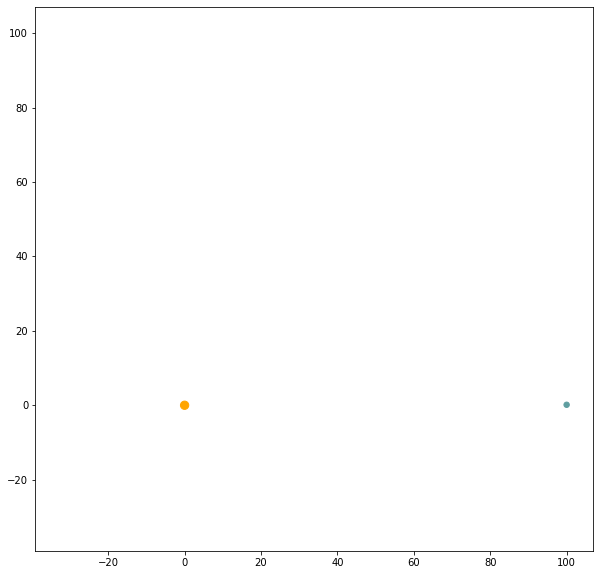

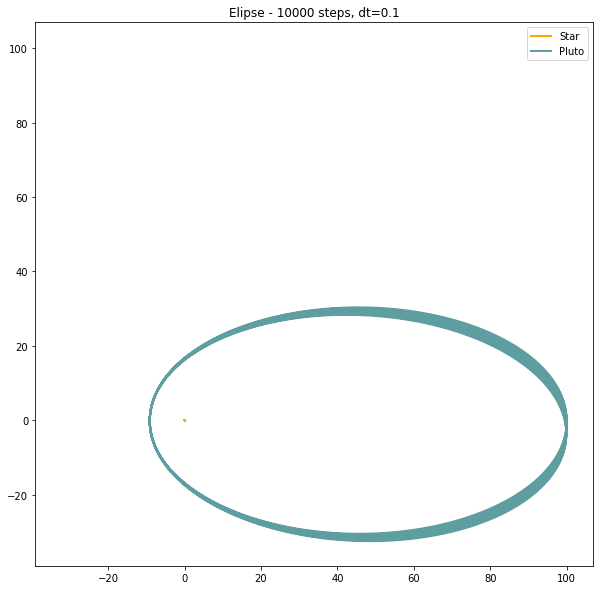

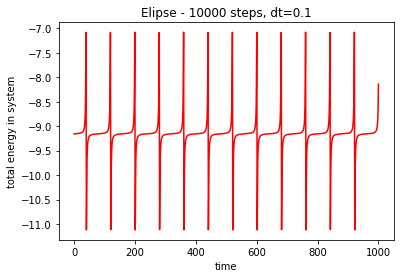

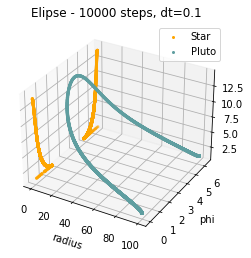



Saving Video
Rendering |██████████████████████████████████████████████████| 100.0% Complete


In [215]:
p = ParticleFactory("Elipse")
p.removeOffsetSpeed()
s = Simulate(h=0.1, n=10000)
a = Animate(p, s.verlet)

a.pathPlot()
a.energyPlot()
a.phaseSpace(True) #True to show 3d, False to show 2d
a.save_video()